# Taylor-Hood elements for Stokes

This miniapp demonstrates a FEM implementation of the incompressible Stokes equations:


\begin{aligned}
\frac{\partial \mathbf{u}}{\partial t} - \nu \nabla^2 \mathbf{u} + \nabla p &= 0 \quad \text{in } \Omega, \\
\nabla \cdot \mathbf{u} &= 0 \quad \text{in } \Omega,
\end{aligned}


---

- Uses **Taylor–Hood elements** for mixed finite element formulation.
- **P2–P1** elements:
  - Velocity: Continuous piecewise **quadratic** functions ($\mathbb{P}_2$)
  - Pressure: Continuous piecewise **linear** functions ($\mathbb{P}_1$)

---

In [16]:
# Import Libraries (Only numpy, matplotlib and scipy are allowed)
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.animation as animation

from scipy.spatial import Delaunay
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.interpolate import griddata


In [17]:
# wget mesh

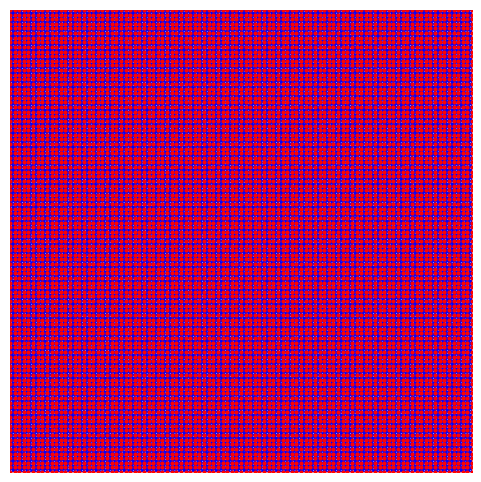

Mesh Summary:
 - Number of nodes: 10201
 - Number of triangles: 20000
 - Domain size: 1 x 1
 - Base Mesh Size: 0.0100 x 0.0100


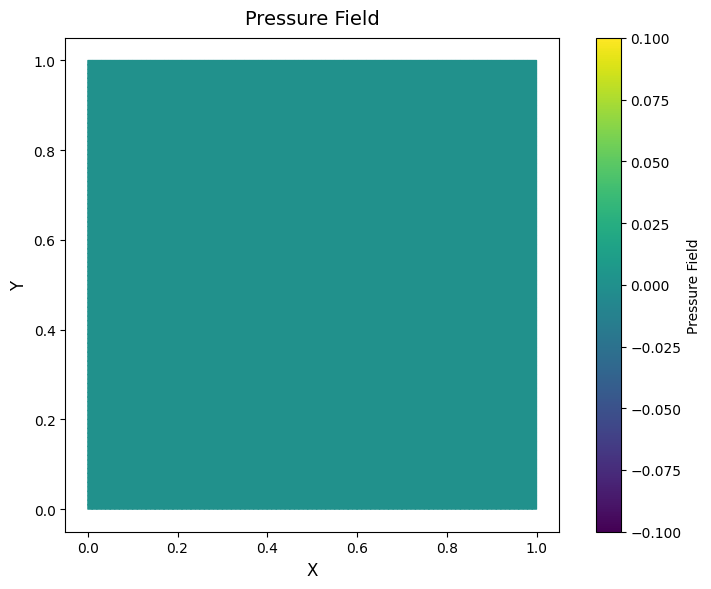

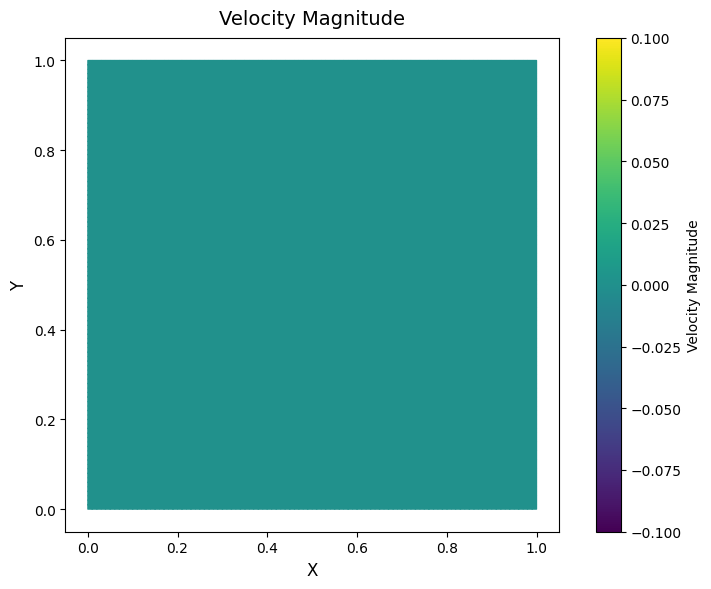

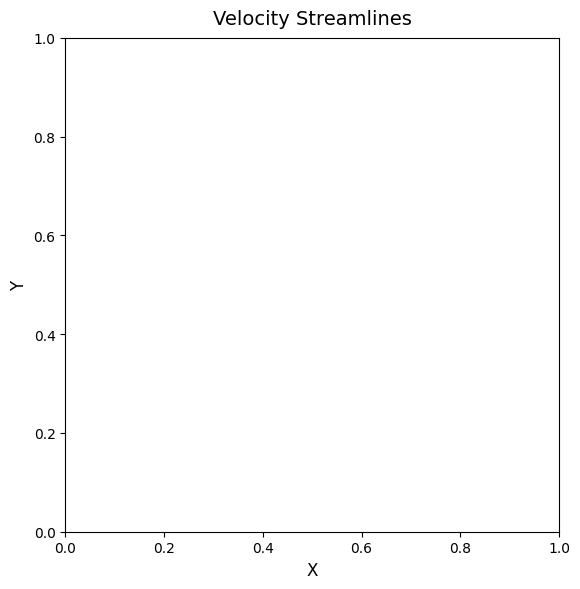

In [18]:
def generate_triangular_mesh(x_len=1, y_len=1, mesh_size=0.1):
    num_x = int(x_len / mesh_size) + 1
    num_y = int(y_len / mesh_size) + 1
    x = np.linspace(0, x_len, num_x)
    y = np.linspace(0, y_len, num_y)
    X, Y = np.meshgrid(x, y)
    points = np.vstack([X.ravel(), Y.ravel()]).T
    triangulation = Delaunay(points)
    mesh = {
        'points': points,
        'triangles': triangulation.simplices,
        'velocity': np.zeros((points.shape[0], 2)),
        'pressure': np.zeros(points.shape[0]),
        'num_x': num_x,
        'num_y': num_y
    }
    return mesh

def plot_mesh(mesh, x_len=1, y_len=1):
    tri_obj = tri.Triangulation(mesh['points'][:, 0], mesh['points'][:, 1], mesh['triangles'])
    plt.figure(figsize=(6, 6))
    plt.triplot(tri_obj, color='blue')
    plt.plot(mesh['points'][:, 0], mesh['points'][:, 1], 'o', color='red', markersize=2)
    plt.xlim(0, x_len)
    plt.ylim(0, y_len)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()
    num_nodes = len(mesh['points'])
    num_triangles = len(mesh['triangles'])
    print(f"Mesh Summary:")
    print(f" - Number of nodes: {num_nodes}")
    print(f" - Number of triangles: {num_triangles}")
    print(f" - Domain size: {x_len} x {y_len}")
    print(f" - Base Mesh Size: {x_len / (mesh['num_x'] - 1):.4f} x {y_len / (mesh['num_y'] - 1):.4f}")

def plot_surface(mesh, field):
    points = mesh['points']
    triangles = mesh['triangles']
    if field == 'pressure':
        values = mesh['pressure']
        title = 'Pressure Field'
    elif field == 'v1':
        values = mesh['velocity'][:, 0]
        title = 'Velocity Component V1'
    elif field == 'v2':
        values = mesh['velocity'][:, 1]
        title = 'Velocity Component V2'
    elif field == 'velocity':
        values = np.linalg.norm(mesh['velocity'], axis=1)
        title = 'Velocity Magnitude'
    else:
        raise ValueError("Field must be 'pressure', 'v1', 'v2', or 'velocity'")
    plt.figure(figsize=(8, 6))
    plt.tripcolor(points[:, 0], points[:, 1], triangles, values, shading='gouraud', cmap='viridis')
    plt.colorbar(label=title)
    plt.title(title, fontsize=14, pad=10)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()

def plot_velocity_streamlines(mesh, x_len=1, y_len=1):
    num_x = mesh['num_x']
    num_y = mesh['num_y']
    x = np.linspace(0, x_len, num_x)
    y = np.linspace(0, y_len, num_y)
    u = mesh['velocity'][:, 0].reshape(num_y, num_x)
    v = mesh['velocity'][:, 1].reshape(num_y, num_x)
    plt.figure(figsize=(8, 6))
    plt.streamplot(x, y, u, v, color='black', linewidth=1, density=1.5)
    plt.title('Velocity Streamlines', fontsize=14, pad=10)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.xlim(0, x_len)
    plt.ylim(0, y_len)
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()
